## Run experiment to synthesize dataset without labelled nodes
This notebook compares run the experiment to synthesize a dataset. The synthesied dataset don't have labels therefore the performance is only measured on 'intrinsic' graph properties. The experiment consists of the following steps and is performed 10 time to account for stochasticity

- train and calculate the graphsage embedding
- train DDPM network and create synthetic nodes.
- for the LSTM, MLP and bi-MLP vairants:
    - train model and create synthetic edges.
    - create synthetic graph
    - measure performance
    - copy relevant data (synthetic graph, embedding to experiment folder)
    - save performance.

In [1]:
# Set root dir
import os
os.chdir('..')
print(os.getcwd())

/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj


In [2]:
# import modules
import pickle
import pathlib
from tigger_package.orchestrator import Orchestrator
from tigger_package.metrics.distribution_metrics import compare_metrics
from tigger_package.tools import plot_adj_matrix, plot_hist
from datetime import datetime, date
import networkx as nx 
import pandas as pd
import time
import glob


loaded


In [5]:
def copy_data(folder, variant_name, run_nr):
    path = pathlib.Path(folder + "exp_results/no_labels")
    path.mkdir(parents=True, exist_ok=True)
    #copy synthetic nodes
    tmp = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
    tmp.to_parquet(folder + f'exp_results/no_labels/node_attributes_{variant_name}_run_{run_nr}.parquet')
    # copy synthetic edges of synth graph
    tmp = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
    tmp.to_parquet(folder + f'exp_results/no_labels/adjacency_{variant_name}_run_{run_nr}.parquet')
    # copy synthetic walks
    obj = pickle.load(open(folder + 'synth_walks.pickle', 'rb'))
    pickle.dump(obj, open(folder + f'exp_results/no_labels/synth_walks_{variant_name}_run_{run_nr}.pickle', 'wb'))
    
def measure_performance(orchestrator, variant_name):
    nodes = orchestrator._load_nodes()
    edges = orchestrator._load_edges()
    lstm_nodes = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
    lstm_edges = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
    res = compare_metrics(nodes, edges, lstm_nodes, lstm_edges, variant_name)
    return res

def run_single_experiment(run_nr, folder):
    # create synthetic nodes and embedding
    orchestrator = Orchestrator(folder)
    orchestrator.create_graphsage_embedding()
    orchestrator.train_node_synthesizer()
    orchestrator.sample_node_synthesizer()

    res = []
    for variant_name in ['LSTM', 'MLP', 'Bi-MLP']:
        #train variant and sample edges
        target_cnt = 2 * orchestrator._load_edges().shape[0]
        orchestrator.init_graphsynthesizer(variant_name, seed=run_nr)
        orchestrator.train_graphsyntesizer()
        orchestrator.create_synthetic_walks(
            synthesizer=orchestrator.graphsynthesizer, 
            target_cnt=target_cnt
        )
               
        # create synth graph
        orchestrator.generate_synth_graph()

        #copy relevant data
        copy_data(folder, variant_name, run_nr)
        
        # measure performance
        res.append(measure_performance(orchestrator, variant_name))
        
    res = (res[0]
           .merge(res[1], on=['name', 'type', 'metric'])
           .merge(res[2], on=['name', 'type', 'metric'])
    )
    res['run_id'] = run_nr
    res['run_tijd'] = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    return res[['name', 'type', 'metric', 'LSTM', 'MLP', 'Bi-MLP','run_id', 'run_tijd']]
  
def  init_res_dataset(folder):
    matching_files = glob.glob(folder + f"exp_results/no_labels/combined_raw_results_*")
    if len(matching_files)> 0:
        max_date = max([int(f.split(".")[0][-8:]) for f in matching_files])
        res_path = f"{folder}exp_results/no_labels/combined_raw_results_{max_date}.parquet"
        res = [pd.read_parquet(res_path)]
        start_run = res[0]['run_id'].max() + 1
    else:
        res = []
        start_run = 0
    return start_run, res

def run_experiment(folder, runs=10):
    start_run, res = init_res_dataset(folder)
    for run_nr in range(start_run, start_run + runs):
        print(f"start processing run {run_nr}")
        res.append(run_single_experiment(run_nr, folder))  
        total_df = pd.concat(res, axis=0)
        date_str = date.today().strftime("%Y%m%d")
        total_df.to_parquet(folder + f"exp_results/no_labels/combined_raw_results_{date_str}.parquet")
    return total_df  

def calculate_Stats(res):
    node_attributes = res[res['type']=='node_attributes'].groupby('run_id').agg({'LSTM': 'mean', 'MLP': 'mean', 'Bi-MLP': 'mean', 'type': 'max'}).reset_index()
    edge_attributes = res[res['type']=='edge_attributes'].groupby('run_id').agg({'LSTM': 'mean', 'MLP': 'mean', 'Bi-MLP': 'mean', 'type': 'max'}).reset_index()
    dif_cluster_coef = res[res['name']=='dif_cluster_coef'][['name', 'LSTM', 'MLP', 'Bi-MLP', 'run_id'] ].rename(columns={'name': 'type'})
    delta_widget = res[res['name']=='mean_delta_widget'][['name', 'LSTM', 'MLP', 'Bi-MLP', 'run_id'] ].rename(columns={'name': 'type'})
    edge_cnt = (res[(res['type']=='edge_cnt') & (res['name']=='edge_count')].set_index('run_id')[['LSTM', 'MLP', 'Bi-MLP']] -  
                res[(res['type']=='edge_cnt') & (res['name']=='orig_edge_count')].set_index('run_id')[['LSTM', 'MLP', 'Bi-MLP']]
    )
    edge_cnt['type'] = "Delta_edge_count"
    edge_cnt = edge_cnt.reset_index(names='run_id')
    cluster_coef = res[res['name'].str.startswith('dif_')][['name', 'LSTM', 'MLP', 'Bi-MLP', 'run_id'] ].rename(columns={'name': 'type'})
    sum_res = pd.concat([node_attributes, edge_attributes, dif_cluster_coef, delta_widget, edge_cnt, cluster_coef], axis=0)
    sum_stat = sum_res.groupby('type').mean()
    return sum_stat      

# ERDOS

start processing run 8
Epoch: 3588, Loss: 0.5579,  Test: 0.5442Early stopping after 3589 epochs with no improvement in validation loss.
Total training time 201.7469s


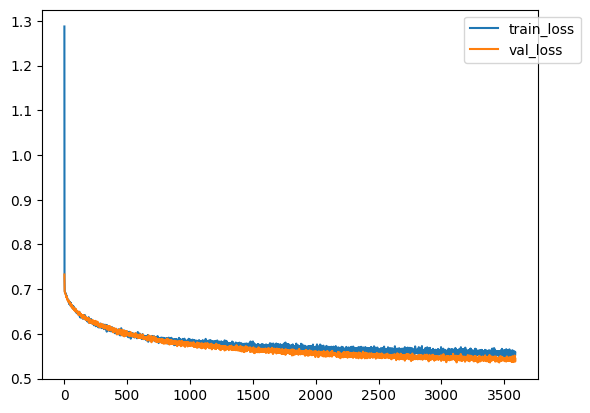

Category dims K: 4
Total number of dim in: 74
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.1}, 'd_in': 74, 'num_classes': 70}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 2048 out of 2000 = 102.4Loss: 0.2111 Sum: 0.5474 val:0.4285 val:0.4683
there are 1000 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/9995 [00:00<?, ?it/s]

Number of components, 22


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

 7680 / 8000, epoch:3999 loss=4.254385471343994, val_loss: 4.85561466217041995

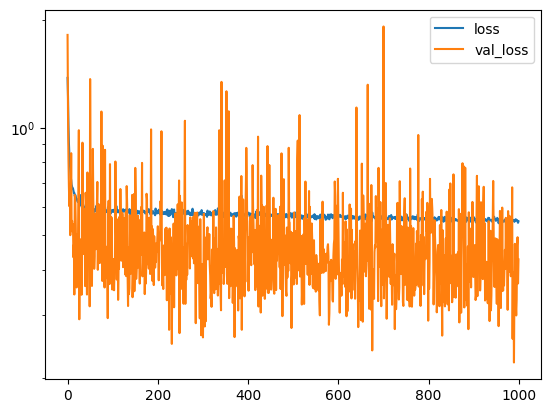

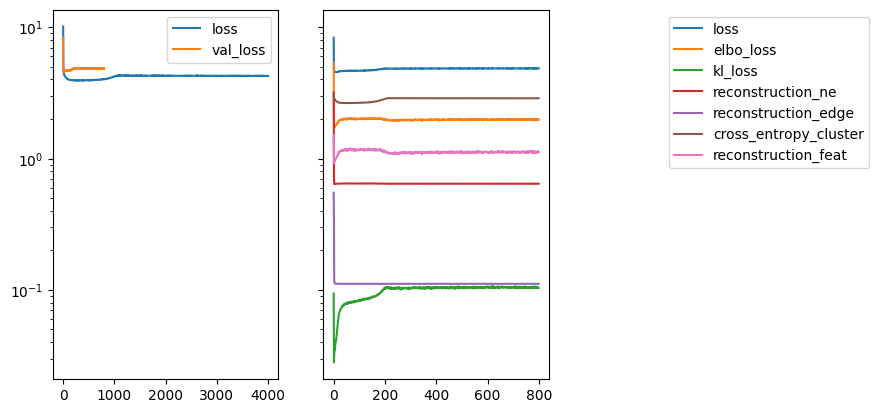

 epoch 300/300 train loss 5.5185 val loss: 5.5483start processing run 9
Epoch: 3022, Loss: 0.5592,  Test: 0.5525Early stopping after 3023 epochs with no improvement in validation loss.
Total training time 198.3799s


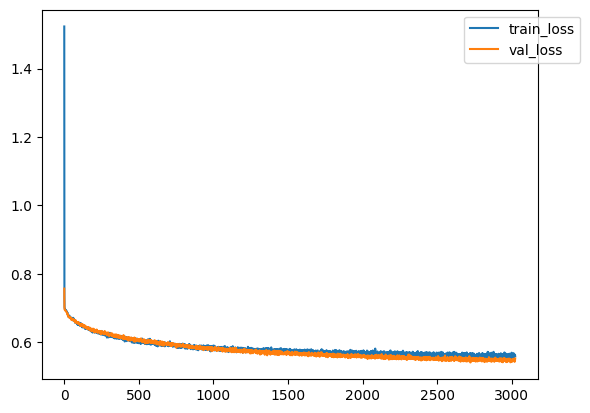

Category dims K: 4
Total number of dim in: 74
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.1}, 'd_in': 74, 'num_classes': 70}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 2048 out of 2000 = 102.4Loss: 0.2088 Sum: 0.5413 val:0.7586 val:0.3729
there are 1000 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/9995 [00:00<?, ?it/s]

Number of components, 22


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

 7680 / 8000, epoch:3999 loss=3.6536412239074707, val_loss: 4.5118350982666025

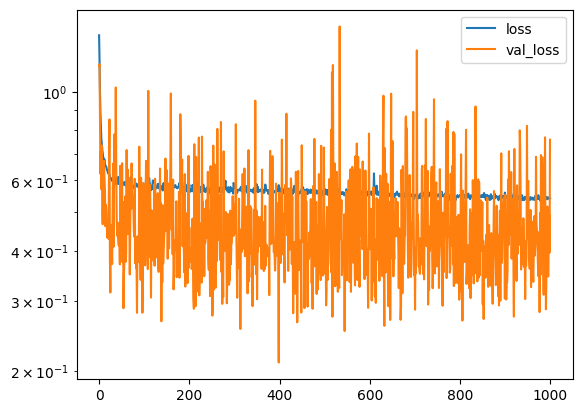

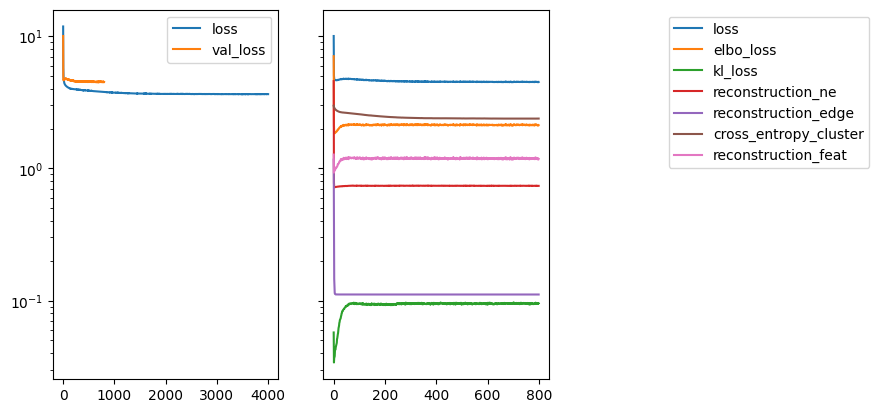

 epoch 300/300 train loss 5.5656 val loss: 5.5813start processing run 10
Epoch: 3449, Loss: 0.5649,  Test: 0.5488Early stopping after 3450 epochs with no improvement in validation loss.
Total training time 202.7004s


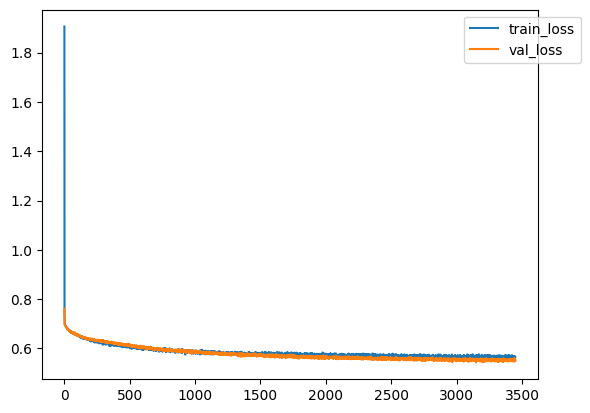

Category dims K: 4
Total number of dim in: 74
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.1}, 'd_in': 74, 'num_classes': 70}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 2048 out of 2000 = 102.4Loss: 0.2083 Sum: 0.5445 val:0.5679val:0.48098
there are 1000 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/9995 [00:00<?, ?it/s]

Number of components, 22


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

 1536 / 8000, epoch:1405 loss=3.552503824234009, val_loss: 4.40719604492187555

KeyboardInterrupt: 

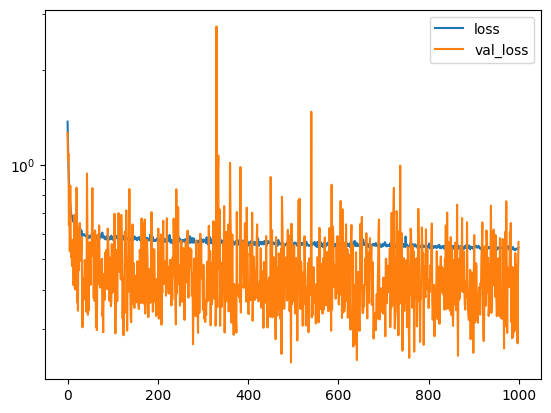

In [9]:
#dataset folder and load orchestrator
folder = "data/erdos/"
res = run_experiment(folder, 3)


In [15]:
_, res = init_res_dataset(folder)
res = res[0]
res

,name,type,metric,LSTM,MLP,Bi-MLP,run_id,run_tijd
0,attr0,node_attributes,Wasserstein_distance,0.009000,0.009000,0.009000,0,06-01-2024 19:01:31
1,attr1,node_attributes,Wasserstein_distance,0.010000,0.010000,0.010000,0,06-01-2024 19:01:31
2,attr2,node_attributes,Wasserstein_distance,0.038122,0.038122,0.038122,0,06-01-2024 19:01:31
3,attr3,node_attributes,Wasserstein_distance,0.022103,0.022103,0.022103,0,06-01-2024 19:01:31
4,attr4,node_attributes,Wasserstein_distance,0.046962,0.046962,0.046962,0,06-01-2024 19:01:31
...,...,...,...,...,...,...,...,...
59,mean_delta_widget,widget_count,fraction,0.115148,0.115990,0.048464,9,10-01-2024 13:40:20
60,edge_count,edge_cnt,count,3783.000000,999.000000,9995.000000,9,10-01-2024 13:40:20
61,orig_edge_count,edge_cnt,count,9995.000000,9995.000000,9995.000000,9,10-01-2024 13:40:20
62,node_count,edge_cnt,count,1000.000000,1000.000000,1000.000000,9,10-01-2024 13:40:20


In [16]:
calculate_Stats(res)

,run_id,LSTM,MLP,Bi-MLP
type,,,,
Delta_edge_count,4.5,-6239.000000,-8682.600000,0.000000
dif_cluster_coef,4.5,0.008701,0.018315,-0.022442
edge_attributes,4.5,0.099240,0.095332,0.028024
mean_delta_widget,4.5,0.115287,0.115980,0.039238
node_attributes,4.5,0.028488,0.028488,0.028488
